In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4.5)

from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from tensorflow.keras import backend as k

# Click-Through Rate Prediction

## Click-Through Rate Prediction

**Let's consider an automatic recommendation problem**

* Given a set of restaurant indexed on a a web platform (think Tripadvisor)
* ...We want to estimate how likely a user is to actually open the restaurant card

**This is know as _click-through rate_**

<center><img src="assets/la-montanara.jpg" width=600px/></center>

This example (and the approach) is based on this [TensorFlow Lattice Tutorail](https://www.tensorflow.org/lattice/tutorials/shape_constraints)

## Loading the Data

**Let's start by loading the dataset**

In [2]:
tr, val, ts = util.load_restaurant_data()
tr.iloc[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,3.927976,122.0,DDDD,1
1,3.927976,122.0,DDDD,0
2,3.927976,122.0,DDDD,0


* There are two numeric attributes, a categorical one, and a target
* Each row represents one visualization event, hence there are _duplicates_

In [3]:
dt_in = ['avg_rating', 'num_reviews', 'dollar_rating']
ndup = np.sum(tr.duplicated(dt_in))
print(f'#examples: {len(tr)}, #duplicated inputs {ndup}')

#examples: 835, #duplicated inputs 395


* The click rate can be inferred by number of clicks for each restaurant

## Target Function

**This is a synthetic dataset, for which we know the target function**

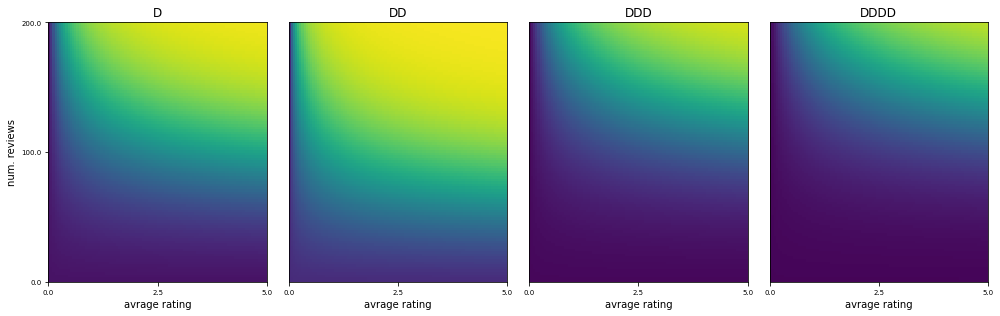

In [4]:
util.plot_ctr_truth(figsize=figsize)

* The click rate _grows with the average rating_ and the _number of reviews_
* Average priced restaurant are clicked the most

## Data Distribution

**Let's check the attribute distribution on the training set**

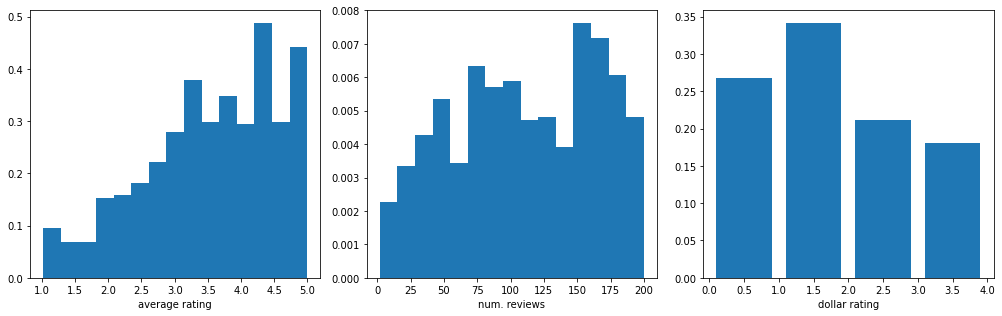

In [5]:
util.plot_ctr_distribution(tr, figsize=figsize)

## Data Distribution

**...And on the test set**

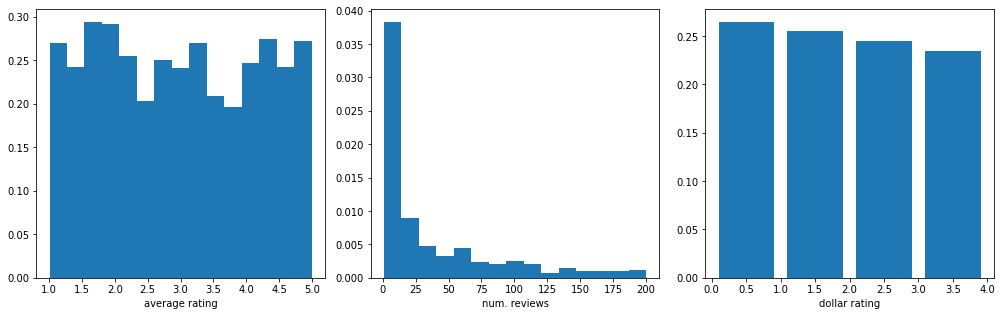

In [6]:
util.plot_ctr_distribution(ts, figsize=figsize)

Here there is _a strong discrepancy w.r.t. the training set_

## Distribution Discrepancy

**What is the reason for the discrepancy?**

A training set for this kind of problem will come from app usage data

* Users seldom scroll through all search results
* ...So their clicks will be biased toward high ranked restaurant

Any training set obtained in this fashion will be _strongly biased_

**However, click rate prediction is typically use for ranking search results**

...Meaning that we will need to evaluate also less viewed restaurants

* In a practical problem, the test set _would not even be available_
* We have it just as a mean for validating our results

A bias in the training can be problematic: we will try to see that in action

# A Baseline Approach

## Preparing the Data

**We will start by tackling the problem using a Multi Layer Perceptron**

We normalize the numeric data:

In [7]:
nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()

tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

We also adopt a one-hot encoding for the categorical data:

In [8]:
tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

## Preparing the Data

**Here is the result of our preparation**

In [9]:
tr_sc

,avg_rating,num_reviews,clicked,dollar_rating_D,dollar_rating_DD,dollar_rating_DDD,dollar_rating_DDDD
0,0.785773,0.610,1.0,0.0,0.0,0.0,1.0
1,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
2,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
3,0.866150,0.610,1.0,0.0,0.0,0.0,1.0
4,0.619945,0.590,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
830,0.597304,0.055,1.0,0.0,1.0,0.0,0.0
831,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
832,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
833,0.688336,0.270,1.0,0.0,1.0,0.0,0.0


## Training the MLP

**We can now train the MLP model**

2022-07-03 17:26:00.028838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


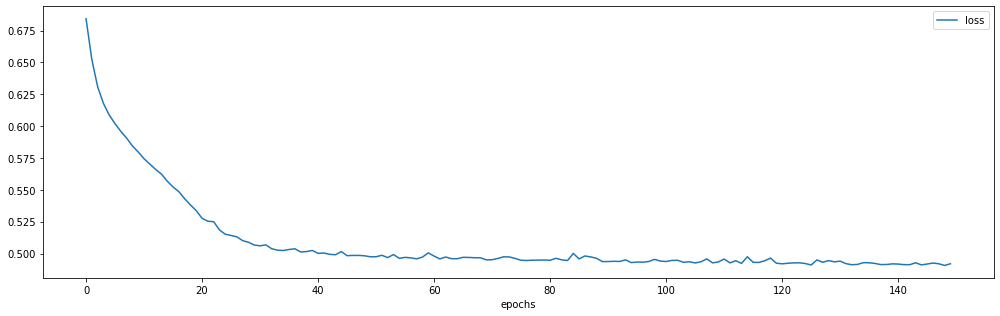

Model loss: 0.4920 (training)


In [10]:
nn = util.build_ml_model(input_size=len(dt_in_c), output_size=1, hidden=[16, 16],
                         output_activation='sigmoid')
history = util.train_ml_model(nn, tr_sc[dt_in_c], tr_sc['clicked'], batch_size=32, epochs=150,
                              validation_split=0.0, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)

## Evaluating the Predictions

**This is not a classification problem, so the accuracy is not a good metric**

* The output of our system is _meant to be interpreted as a probability_
* ...So, rounding to obtain a deterministic prediction may be too restrictive

**Instead, we will make a first evaluation using a _ROC curve_**

A Receiver Operating Characteristic curve is a type of plot

* We consider multiple threshold values
  - Each threshold is meant to be used for discriminating between classes
  - The usual rounding approach is equivalent to a 0.5 threshold
* On the $x$ axis, we report the false positive rate for each threshold
* On the $y$ axis, we report the true positive rate for each threshold

## Evaluating the Predictions

**A ROC curve looks like this** (image from wikipedia)

<center><img src="assets/Roccurves.png" width=500px/></center>

* The large the Area Under Curve (AUC), the better the performance
* The AUC value is guaranteed to be in the $[0, 1]$ interval

## Evaluating the Predictions

**Let's compute the AUC values for all sets**

In [11]:
pred_tr = nn.predict(tr_sc[dt_in_c])
pred_val = nn.predict(val_sc[dt_in_c])
pred_ts = nn.predict(ts_sc[dt_in_c])
auc_tr = roc_auc_score(tr_sc['clicked'], pred_tr)
auc_val = roc_auc_score(val_sc['clicked'], pred_val)
auc_ts = roc_auc_score(ts_sc['clicked'], pred_ts)
print(f'AUC score: {auc_tr:.2f} (training), {auc_val:.2f} (validation), {auc_ts:.2f} (test)')

AUC score: 0.82 (training), 0.81 (validation), 0.78 (test)


* The model works well on the training distribution
* ...But a little worse on the testing data

## Issues with the MLP

**Let's check the full (prediction) _output space for the MLP_**

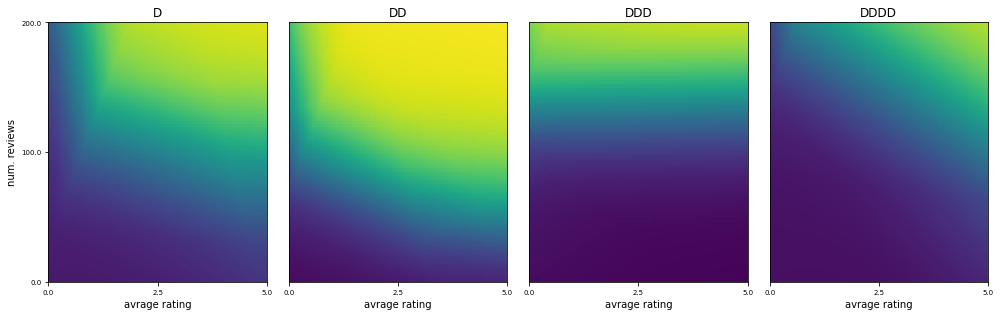

In [12]:
util.plot_ctr_estimation(nn, scale, figsize=figsize)

* Some of the expected monotonicities _may not respected_
* ...And this is a critical problem in some cases!

# Projected Gradient Method

## Shape Constraints

**Monotonicity are an example of _shape constraints_**

Shape constraints are restrictions on the shape of the input-output function, e.g.:

* Monotonicity (e.g. "the output should grow when an input grows")
* Convexity/concavity (e.g. "the output should be convex w.r.t. an input")

**Shape constraints are _very common_ in industrial applications**

Some examples:

* Opening a valve is going to increase the power output (monotonicity)
* Reducing the price will raise the sales volume (monotonicity)
* Too low/high temperatures will lead to worse bakery products (convexity)
* Massive price reductions will be less effective (monotonicity + convexity)

**How can they be implemented?**

## Implementing Shape Constraints

**In some cases, shape constraints translate _onto the model parameters_**

Consider a linear regressor:

$$
f(x, \omega) = \omega_{1..n}^T x + \omega_0
$$

* Where $\omega_0, \ldots \omega_n$ is the weight vector ($\omega_0$ is the intercept)

**In this context**

* An increasing monotoniticiy w.r.t. all attributes $x_{j}$ with $j \in J$
* ...Is equivalent to the constraints $\omega_{j} \geq 0 \ \forall j \in J$

**In other words:**

* We started from constraints in the shape of the input-output functions
* ...And we transformed it into a constraints on the model parameters

## Implementing Shape Constraints

**Then, training consists in solving:**

$$
\text{argmin}_{\omega} \{L(f(\hat{x}, \omega)) \mid \omega_{j} \geq 0 \  \forall j \in J \}
$$

Where:

* $\{\hat{x}, \hat{y}\}$ is the training set
* $L(y)$ is the MSE loss, i.e. $L(y) = 1/n \|y - \hat{y}\|_2^2$

**This is a _constrained optimization_ problem**

* It cannot be solved via the Linear Least Squares method
* ...And neither via gradient descent

**So, what can we use instead?**

## Projected Gradient Method

**A potential approach is the [projected gradient method](https://dl.acm.org/doi/abs/10.1561/2400000003)**

We will explain how to use the method to tackle ML problems in the form:

$$
\text{argmin}_{\omega} \left\{ L(f(\hat{x}, \omega)) \mid \omega \in C \right\}
$$

**Here $C$ is a _generic feasible set_**

* In our case, $C = \{\omega \mid \omega_j \geq 0 \ \forall j \in J\}$
* ...But much more general constraints could be captured in principle

**There are some assumptions:**

* $L$ needs to be differentiable (we will use a gradient)
* If both $L$ and $C$ are convex, we converge to a global optimum
* ...Otherwise we can still find a local optimum (in some cases)

## Projected Gradient Method

**The projected gradient method is an iterative process**

Each iteration is defined by the equations:

$$\begin{align}
\omega^{(k+1)} &= {\bf proj}_{C} \left(\omega^{(k)} - \eta^{(k)} \nabla_{\omega} L\left(f\left(\hat{x}, \omega^{(k)}\right)\right) \right) \\
{\bf proj}_{C}(\omega) &= \text{argmin}_{\omega^\prime} \left\{\frac{1}{2}\|\omega^\prime - \omega\|_2^2 \mid \omega \in C \right\}
\end{align}
$$

Intuitively:

* First we perform a gradient descent step
* Then we _project_ the parameter vector on the feasible space
* Projection = the feasible point with smallest $L_2$ distance

## Projected Gradient Method in Our Example

**In our case, given the current weight vector $\omega^{(k)}$**

First we perform a gradient descent step to obtain:

$$
\tilde{\omega}^{(k+1)} = \omega^{(k)} - \eta^{(k)} \nabla_{\omega} L\left(f\left(\hat{x}, \omega^{(k)}\right)\right)
$$

Then we need to solve the projection step:

$$
\omega^{(k+1)} = \text{argmin}_{\omega^\prime} \left\{\frac{1}{2}\|\omega^\prime - \tilde{\omega}^{(k+1)} \|_2^2 \mid \omega_j \geq 0 \ \forall j \in J \right\}
$$

* In practice we need to _clip at 0_ every $\tilde{\omega}^{(k)}_j$ with $j \in J$

**This case is simple and useful enough to be implemented in many libraries**

## Limitations of the Approach

**Could we use this for Deep Learning?**

* Convexity does not hold for deep networks
* ...But that's not a critical issues (local optima may be nice enough)

**The real issue is the _lack of interpretability_**

* Since NN (and deep nets in particular) are opaque
* ...It's very difficult to define meaningful constraints on their weights

In the cases where this can be done, the PG method is viable

> **...But in general we need a _more interpretable_ model type**

We'll see an example now...

# Lattice Models

## Lattice Models

**Lattice models are a form of piecewise linear interpolated model**

<center><img src="assets/lattice.png" width=400px/></center>

* They are defined over _a grid on their input variables_
* Their parameters are _the output values at each grid points_
* The remaining output values are linearly interpolated

**They are available in tensorflow via [the tensorflow-lattice module](https://www.tensorflow.org/lattice/overview)**

## Lattice Models

**Lattice models:**

* Can represent non-linear multivariate functions
* Can be trained by (e.g.) gradient descent

**The grid is defined by splitting each input domain into intervals**

* The domain of variable $x_i$ is split by choosing a fixed set of $n_i$ "knots"
* The input variables have bounded domains (namely $[0, n_i-1]$)
* ...Of course this leads to scalability issues: we will discuss them later

**The lattice parameters are _interpretable_**

They simply represent output values for certain input vectors 

* They can be changed with very predictable effects
* They can be _constrained_ so that the model behaves in a desired fashion
* If we use hard constraints, we get a _guaranteed behavior_


## Implementing a Lattice Model

**The first step for implementing a lattice model is choosing the lattice size**

In [13]:
lattice_sizes = [4] * 2 + [2] * 4

* We are using 4 knots for numeric inputs and 2 knots for the boolean inputs

**Next, we need to split the individual input columns**

In [14]:
tr_ls = [tr_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]
val_ls = [val_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]
ts_ls = [ts_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]

* This step is required by the tensorflow-lattice API
* We also scale the input to the range expected by the lattice

## Implementing a Lattice Model

**The we build the symbolic tensors for the model input**

In [15]:
mdl_inputs = []
for cname in dt_in_c:
    cname_in = layers.Input(shape=[1], name=cname)
    mdl_inputs.append(cname_in)

* We have one tensor per input column

**Finally we can build our lattice model**

In [16]:
import tensorflow_lattice as tfl

mdl_out = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    output_min=0, output_max=1,
    name='lattice',
)(mdl_inputs)

lm = keras.Model(mdl_inputs, mdl_out)

## Implementing a Lattice Model

**We can plot the model structure**

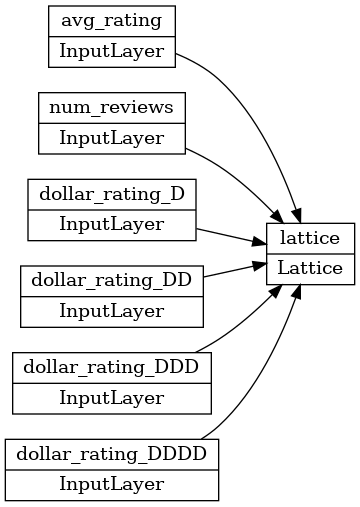

In [17]:
keras.utils.plot_model(lm, rankdir='LR')

## Implementing a Lattice Model

**We can train the model as usual**

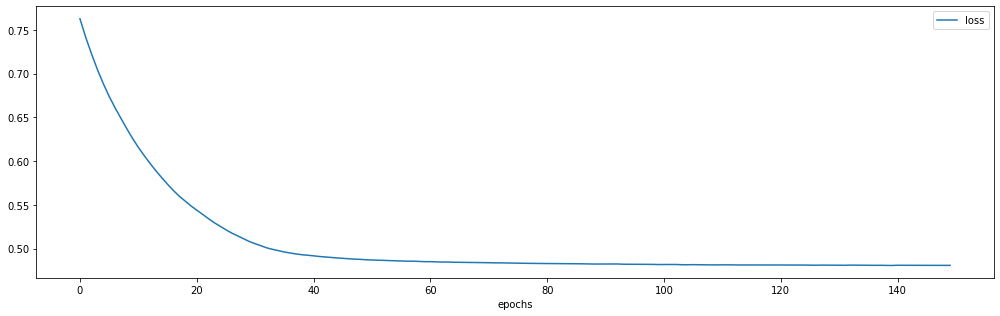

Model loss: 0.4809 (training)


In [18]:
history = util.train_ml_model(lm, tr_ls, tr_sc['clicked'], batch_size=32, epochs=150,
                              validation_split=0.0, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)

## Lattice Model Evaluation

**A large enough lattice model can peform as well as a Deep Network**

Let's see the performance in terms of AUC

In [19]:
pred_tr2 = lm.predict(tr_ls)
pred_val2 = lm.predict(val_ls)
pred_ts2 = lm.predict(ts_ls)
auc_tr2 = roc_auc_score(tr_sc['clicked'], pred_tr2)
auc_val2 = roc_auc_score(val_sc['clicked'], pred_val2)
auc_ts2 = roc_auc_score(ts_sc['clicked'], pred_ts2)
print(f'AUC score: {auc_tr2:.2f} (training), {auc_val2:.2f} (validation), {auc_ts2:.2f} (test)')

AUC score: 0.82 (training), 0.79 (validation), 0.76 (test)


* It is indeed comparable to that of the deep MLP
* ...Also in the fact that it works poorly on the test distribution

## Lattice Model Evaluation

**...But it can behave also just as poorly (or even worse)**

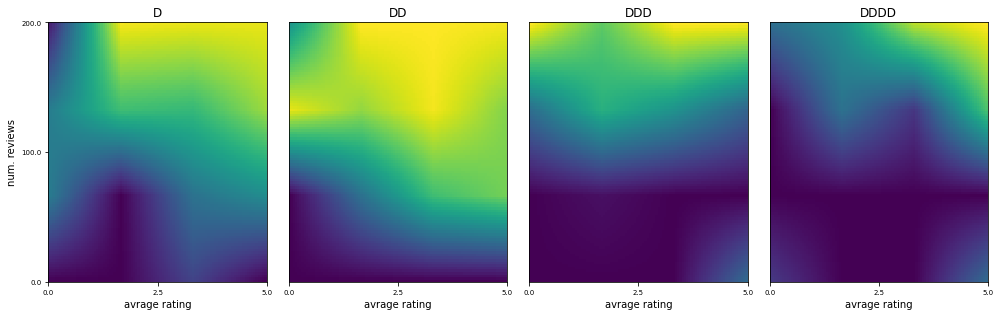

In [20]:
lscale = scale / [s-1 for s in lattice_sizes[:2]]
util.plot_ctr_estimation(lm, lscale, split_input=True, figsize=figsize)

* The expected monotonicity constraints are still violated
* There are still many mistakes for less represented areas of the input space

# Calibration

## Calibration

**Let's start fixing some of the outstanding issues**

In a lattice model, the number of grid points if given by:
$$
n = \prod_{i=1}^m n_i
$$
* ...Hence the parameter number scales _exponentially_ with the number of inputs
* So that modeling complex non-linear function seems to come at a steep cost

**In tensorflow-lattice, scalability issues are mitigated via two approaches:**

* Ensembles of small lattices (we will not cover this one)
* Applying a _calibration_ step to each input variables

We will focus on this latter approach


## Calibration for Numeric Inputs

**Calibration for _numeric attributes_...**

...Consists in applying a piecewise linear transformation to each input

<center><img src="assets/pwl.png" width=600px/></center>

* This is essentially a 1-D lattice
* Calibration parameters are the function value at all knots
* Calibration allows to introduce complexity, without increasing the lattice size

## Calibration for Categorical Inputs

**Calibration for _categorical inputs_...**

...Consists in applying a map:

<center><img src="assets/BarChart.png" width=700px/></center>

* Categorical inputs must be encodeded as integers
* Each input value is mapped to value
* There is one parameter for each possible input value

## Calibration

**Calibration allows enables the use of _fewer knots in the lattice_**

* E.g. 5 knots per input, single lattice: $5 \times 5 = 25$ parameters
* Wherease 5 calibration knots + 2 lattice knots: $5\times 2 + 2 \times 2 = 14$
* Additionally, we tend to get _more regular results_

**Calibration enables using categorical inputs without a one-hot encoding**

...Since the calibration map is almost equivalent

* E.g. 5 categories, no calibration: $2 \times 5 = 10$ parameters
* Whereas with calibration: $5 + 2 = 7$ parameters

**We can therefore adjust our lattice sizes accordingly**

We will use just two knots per dimension

In [36]:
lattice_sizes2 = [2] * 3

## Preparing the Input

**First, we need to encode out categorical input using integers**

We start by converting our string data input pandas categories

In [37]:
tr_sc2 = tr_s.copy()
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].astype('category')
tr_sc2[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,0.785773,0.61,DDDD,1
1,0.785773,0.61,DDDD,0
2,0.785773,0.61,DDDD,0


We can check how the categories are mapped into integer codes:

In [38]:
tr_sc2['dollar_rating'].cat.categories

Index(['D', 'DD', 'DDD', 'DDDD'], dtype='object')

* The codes are are the positional indexes of the strings

## Preparing the Input

**Now we replace the category data with the codes themselves**

In [39]:
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].cat.codes
tr_sc2['dollar_rating'][:3]

0    3
1    3
2    3
Name: dollar_rating, dtype: int8

...And we apply the same treatment to the validation and test set:

In [40]:
val_sc2 = val_s.copy()
val_sc2['dollar_rating'] = val_sc2['dollar_rating'].astype('category').cat.codes

ts_sc2 = ts_s.copy()
ts_sc2['dollar_rating'] = ts_sc2['dollar_rating'].astype('category').cat.codes

## Piecewise Linear Calibration

**We use `PWLCalibration` objects for all numeric inputs**

In [41]:
avg_rating = layers.Input(shape=[1], name='avg_rating')
avg_rating_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc2['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[0] - 1.0,
    name='avg_rating_cal'
)(avg_rating)

num_reviews = layers.Input(shape=[1], name='num_reviews')
num_reviews_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[1] - 1.0,
    name='num_reviews_cal'
)(num_reviews)

* The knot position must be a-priori defined
* ...And we use the training distribution _quantiles_

## Categorical Calibration

**We use `CategoricalCalibration` objects for the categorical input**

In [42]:
dollar_rating = layers.Input(shape=[1], name='dollar_rating')
dollar_rating_cal = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes2[2] - 1.0,
    name='dollar_rating_cal'
)(dollar_rating)

* We use one "bucket" for each possible category

**We should also remember to split the training data**

## Building the Calibrated Lattice Model

**We can now build the lattice model**

In [43]:
lt_inputs2 = [avg_rating_cal, num_reviews_cal, dollar_rating_cal]

mdl_out2 = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes2,
    output_min=0, output_max=1,
    name='lattice',
)(lt_inputs2)

mdl_inputs2 = [avg_rating, num_reviews, dollar_rating]
lm2 = keras.Model(mdl_inputs2, mdl_out2)

**We can compare the number of parameters**

In [44]:
print(f'#Parameters in the original lattice: {sum(len(w) for w in lm.get_weights())}')
print(f'#Parameters in the new lattice: {sum(len(w) for w in lm2.get_weights())}')

#Parameters in the original lattice: 256
#Parameters in the new lattice: 52


## Building the Calibrated Lattice Model

**Let's see which kind of architecture we have now:**

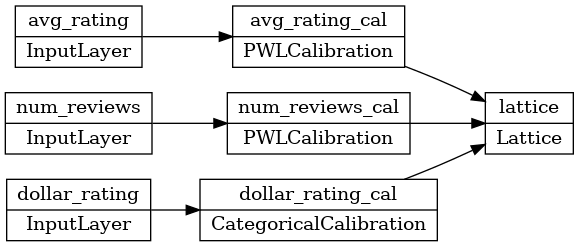

In [45]:
keras.utils.plot_model(lm2, rankdir='LR')

**Now we need to split the training data to enable training**

In [46]:
tr_ls2 = [tr_sc2[c] for c in dt_in]
val_ls2 = [val_sc2[c] for c in dt_in]
ts_ls2 = [ts_sc2[c] for c in dt_in]

## Training the Calibrated Lattice

**We can train the new model as usual**

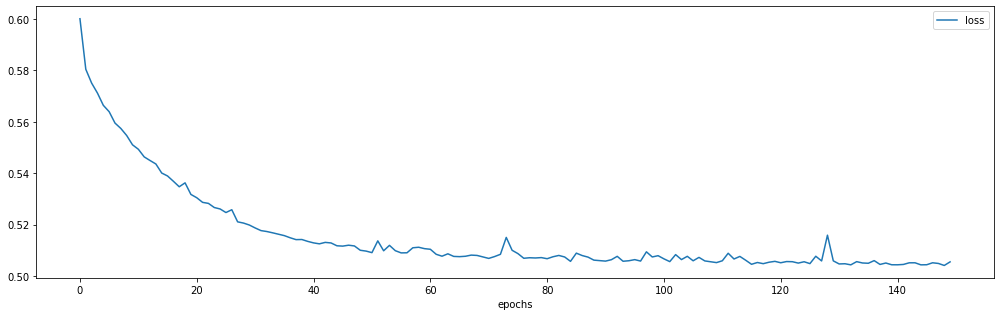

Model loss: 0.5055 (training)
AUC score: 0.80 (training), 0.80 (validation), 0.80 (test)


In [47]:
history = util.train_ml_model(lm2, tr_ls2, tr_sc['clicked'], batch_size=32, epochs=150,
                              validation_split=0.0, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)
pred_tr3, pred_val3, pred_ts3 = lm2.predict(tr_ls2), lm2.predict(val_ls2), lm2.predict(ts_ls2)
auc_tr3, auc_val3, auc_ts3 = roc_auc_score(tr_s['clicked'], pred_tr3), roc_auc_score(val_s['clicked'], pred_val3), roc_auc_score(ts_s['clicked'], pred_ts3)
print(f'AUC score: {auc_tr3:.2f} (training), {auc_val3:.2f} (validation), {auc_ts3:.2f} (test)')

## Inspecting the Calibrated Lattice

**We can inspect the learned function visually to get a better insight**

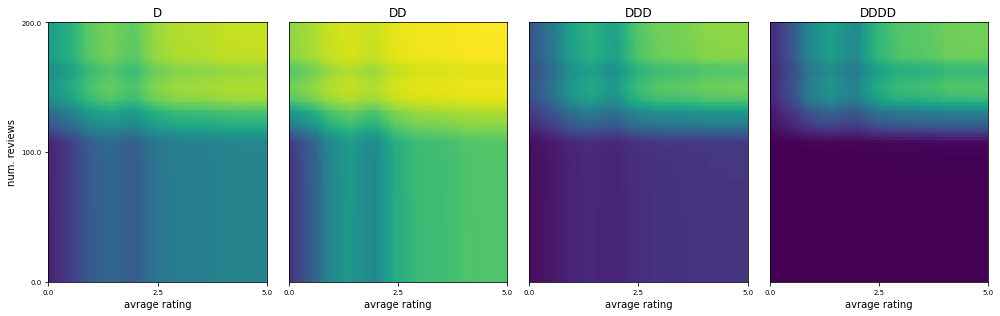

In [48]:
util.plot_ctr_estimation(lm2, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* The structure follows a (piecewise linear) "tartan pattern" 
* This is particularly evident now, since we use just two knots per dimension

## Inspecting the Calibrated Lattice

**It is useful to inspect the calibration layers**

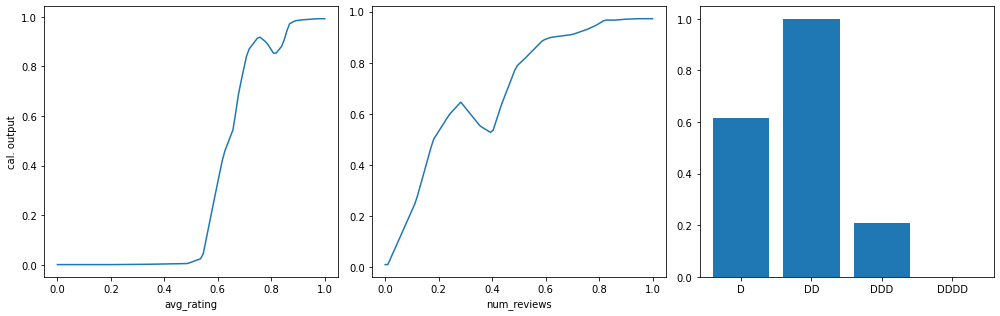

In [49]:
calibrators = [keras.Model(mdl_inputs2[i], lt_inputs2[i]) for i in range(3)]
util.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* The learned calibration functions violate the expected monotonicities

**We cannot confidently show results like this to a customer**

# Shape Constraints

## Shape Constraints

**With lattice models, shape constraints can be stated on the parameters**

* Let $\theta_{i, k, \neg i, \neg k}$ be the parameter for the $k$-th note of input $i$...
* ...While all the remaining attributes and knots (i.e. $\neg i$ and $\neg k$) are fixed

**Then (increasing) _monotonicity_ translates to:**
$$
\theta_{i,k,\neg i,\neg k} \leq \theta_{i,k+1,\neg i,\neg k}
$$

* I.e. all else being equal, the lattice value at the grid points must be increasing
* Decreasing monotonicity is just the inverse

**Then _convexity_ translates to:**
$$
\left(\theta_{i,k+1,\neg i,\neg k} - \theta_{i,k,\neg i,\neg k}\right) \leq \left(\theta_{i,k+2,\neg i,\neg k} - \theta_{i,k+1,\neg i,\neg k}\right)
$$

* I.e. all else being equal, the adjacent parameter _differences_ should increase

## Monotonicity and Smoothness

**We can expect a monotonic effect of the average rating**

I.e. Restaurants with a high rating will be clicked more often

In [50]:
avg_rating2 = layers.Input(shape=[1], name='avg_rating')
avg_rating_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[0] - 1.0,
    monotonicity='increasing',
    kernel_regularizer=('hessian', 0, 1),
    name='avg_rating_cal'
)(avg_rating2)

* The "hessian" regularizer penalizes the second derivative
  - ...Thus making the calibrator more linear
* The two parameters are an L1 weight and L2 weights

## Diminishing Returns

**We can expect a diminishing returns from the number of reviews**

* I.e. a restaurant with 200 reviews will be clicked much more than one with 10
* ...But not much more than one with 150

In [51]:
num_reviews2 = layers.Input(shape=[1], name='num_reviews')
num_reviews_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[1] - 1.0,
    monotonicity='increasing',
    convexity='concave',
    kernel_regularizer=('wrinkle', 0, 1),
    name='num_reviews_cal'
)(num_reviews2)

* By coupling monotonicity with concavity we enforce diminishing returns
* The "wrinkle" regularizer penalizes the third derivative
  - ...Thus making the regularizer smoother

## Partial Orders on Categories

**We can expect more clicks for reasonably priced restaurants...**

...At least compared to very cheap and very expensive ones

In [52]:
dollar_rating2 = layers.Input(shape=[1], name='dollar_rating')
dollar_rating_cal2 = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes2[2] - 1.0,
    monotonicities=[(0, 1), (3, 1)],
    name='dollar_rating_cal'
)(dollar_rating2)

* On categorical attributes, we can enforce partial order constraints
* Each $(i, j)$ pair translates into an inequality $\theta_i \leq \theta_j$
* Here we specify that "D" and "DDDD" will tend to have fewer clicks than "DD"

## Lattice Model with Shape Constraints

**Then we can build the actual lattice model**

In [53]:
lt_inputs3 = [avg_rating_cal2, num_reviews_cal2, dollar_rating_cal2]

mdl_out3 = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes2,
    output_min=0, output_max=1,
    monotonicities=['increasing'] * 3,
    name='lattice',
)(lt_inputs3)

mdl_inputs3 = [avg_rating2, num_reviews2, dollar_rating2]
lm3 = keras.Model(mdl_inputs3, mdl_out3)

* With monotonicities in the calibration layers, the lattice must be monotone, too
* In this case the lattice monotonicities should always be "increasing"
* ...Since two "decreasing" monotonicies would lead to an "increasing" one

## Lattice Model with Shape Constraints

**Let's train the constrained model**

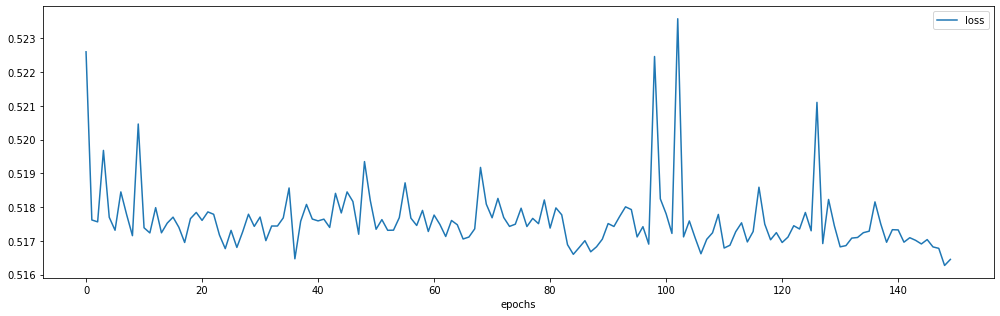

Model loss: 0.5164 (training)
AUC score: 0.80 (training), 0.80 (validation), 0.80 (test)


In [55]:
history = util.train_ml_model(lm3, tr_ls2, tr_sc['clicked'], batch_size=32, epochs=150,
                              validation_split=0.0, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)
pred_tr4, pred_val4, pred_ts4 = lm3.predict(tr_ls2), lm3.predict(val_ls2), lm3.predict(ts_ls2)
auc_tr4, auc_val4, auc_ts4 = roc_auc_score(tr_s['clicked'], pred_tr3), roc_auc_score(val_s['clicked'], pred_val3), roc_auc_score(ts_s['clicked'], pred_ts3)
print(f'AUC score: {auc_tr4:.2f} (training), {auc_val4:.2f} (validation), {auc_ts4:.2f} (test)')

## Inspecting the Calibrated Lattice

**Let's inspect the learned function**

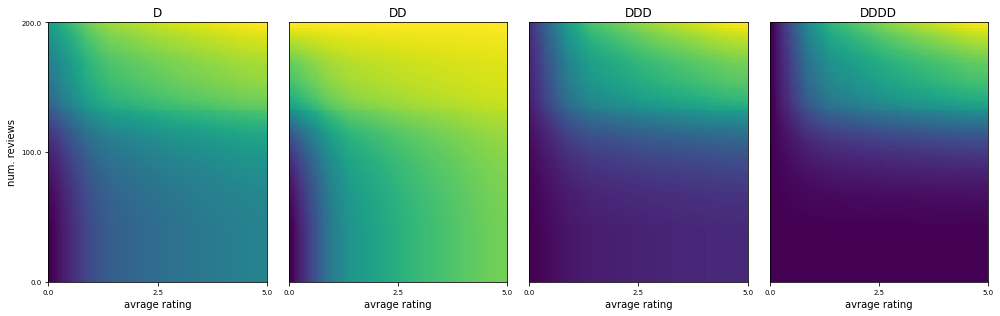

In [56]:
util.plot_ctr_estimation(lm3, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* All monotonicities are respected, the functions are much more regular
* Tartan-pattern apart, they closely match our ground truth

## Inspecting the Calibrated Lattice

**The most interesting changes will be in the calibration functions**

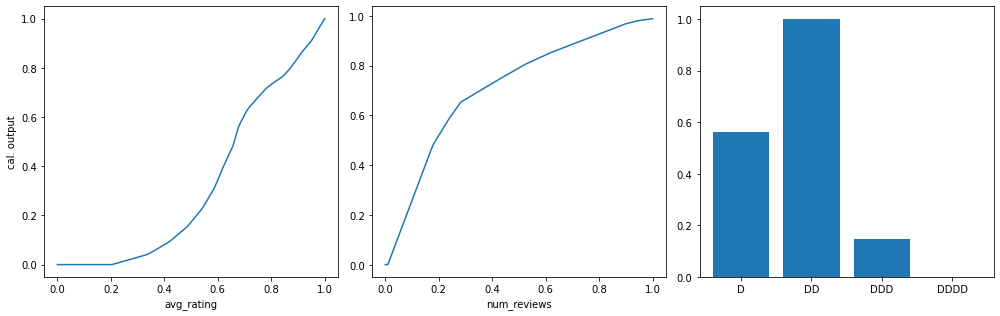

In [57]:
calibrators = [keras.Model(mdl_inputs3[i], lt_inputs3[i]) for i in range(3)]
util.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* Indeed, all monotonicities are respected
* The `avg_rating` regularizer is more linear
* The `num_reviews` one is convex and smooth

## Considerations

**Lattice models are little known, but they can be _very useful_**

* They are interpretable
* Customer react (very) poorly to violation of known properties

**In general, shape constraints are related to the topic of _reliability_**

* I.e. the ability of a ML model to respect basic properties
* ...Especially in areas of the input space not well covered by the training set

Reliability is a very important topic for many applications of AI methods

**Calibration is not restricted to the lattice input**

* Indeed, we can add a calibration layer on the output as well
* ...So that we gain flexibility at a cost of a few more parameters

## Some References

* Parikh, Neal, and Stephen Boyd. "Proximal algorithms." Foundations and trends® in Optimization 1.3 (2014): 127-239.
* Seungil You, David Ding, Kevin Robert Canini, Jan Pfeifer, Maya R. Gupta: Deep Lattice Networks and Partial Monotonic Functions. NIPS 2017: 2981-2989
* Maya R. Gupta, Andrew Cotter, Jan Pfeifer, Konstantin Voevodski, Kevin Robert Canini, Alexander Mangylov, Wojtek Moczydlowski, Alexander Van Esbroeck: Monotonic Calibrated Interpolated Look-Up Tables. J. Mach. Learn. Res. 17: 109:1-109:47 (2016)
* Maya R. Gupta, Dara Bahri, Andrew Cotter, Kevin Robert Canini: Diminishing Returns Shape Constraints for Interpretability and Regularization. NeurIPS 2018: 6835-6845